# Tanner Murphey (cmurphey)
# Final Project: H-R Diagram fitting using GAIA data and Markov-Chain Monte Carlo

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import pymc3 as pm
import theano.tensor as T
%matplotlib inline
%pylab inline

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Populating the interactive namespace from numpy and matplotlib


**Please check the README to make sure all libraries and data are there**

I'm going to trim down noisy measurements because, especially at very low parallax, that can drastically alter the estimated distance which messes up the apparent-to-absolute magnitude conversion. Also, trying to run the analysis further down for the whole set on my laptop causes my IDE to crash, so we might as well just work with the highest quality data of the set. There isn't any light extinction data so I just have to ignore it/hope it isn't too significant. Then, in order for the MCMC to work, we need to eliminate any NaNs that can appear in the data. There should still be plenty of data left over, so this shouldn't make too much of a difference.

In [2]:
cutoff = 50 # parallax to error threshold
data = pd.read_csv("GaiaSource_786097-786431.csv.gz")
data = data[data['parallax_over_error'] > cutoff]
data = data[~np.isnan(data['bp_rp'])] #there are some nans in here that will mess up calculations

To prove that there's still plenty of points for an H-R diagram:

In [3]:
print(len(data))

6121


In [4]:
distance = 1 / (data['parallax']*1000) # parsec from milliarcseconds

dist_modulus = -2.5*(distance/10) # distance modulus

abs_g_mag = np.array(data['phot_g_mean_mag'] - dist_modulus)

I guess, just out of curiosity, let's see where these stars are with respect to the sun. I'll also add the galactic center just for an extra reference so we have a better idea of the scale

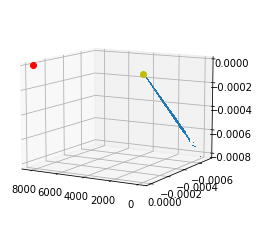

In [5]:
x = distance * np.cos((data['b'])*np.pi/180)*np.cos(data['b']*np.pi/180)
y = distance * np.cos(data['b']*np.pi/180)*np.sin(data['b']*np.pi/180)
z = distance * np.sin(data['b']*np.pi/180)

ax = plt.axes(projection='3d')
ax.plot(x, y, z, ',')
ax.plot(8200, 0, 0, 'ro') # Galactic center
ax.plot(0, 0, 0, 'yo') # sun
ax.view_init(10, 120)

Now, lets make an H-R diagram:

In [6]:
distance = 1000/data['parallax'] # parsec
dist_modulus = -2.5*np.log10(distance / 10) #distance modulus magnitude loss

g_abs_mag = data['phot_g_mean_mag'] + dist_modulus

Text(0.5, 1.0, 'H-R Diagram of 4 GAIA Data Collections')

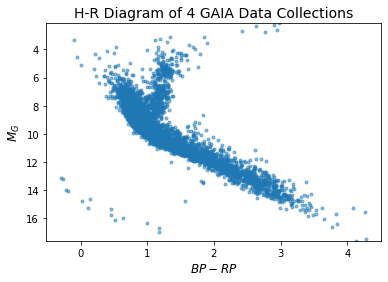

In [7]:
plt.plot(data['bp_rp'], g_abs_mag, '.', alpha=0.5)
plt.ylim(max(g_abs_mag), min(g_abs_mag)) # because magnitudes
plt.ylabel(r"$M_G$", size=12)
plt.xlabel(r"$BP - RP$", size=12)
plt.title("H-R Diagram of 4 GAIA Data Collections", size=14)

As I said above, we are ignoring magnitude losses due to dust. I have a strong feeling that that is a significant contributor to the thickness of the main sequence line but we do not have light extinction data so we can't account for it. This also is only the G-band absolute magnitude which, [according to GAIA's website](https://www.cosmos.esa.int/web/gaia/iow_20180316) covers most of the visible band. This obviously isn't the bolometric magnitude but that isn't available in the dataset and this is the closest we have since GAIA's G-band covers essentially all of it's other bands.

That being said, it looks like a pretty solid H-R diagram. The main sequence is very visible and there are several stars in the giants areas and some white dwarfs. 

I guess this would be a good time to see if we can sort out if these stars are on the main sequence or not and then see if we can fit a line. We'll do that with PyMC3

In [8]:
with pm.Model() as model:
    m = pm.Normal("m", 3, 2, testval=3)
    b = pm.Normal("b", 6, 1, testval=6)
    xs = np.array(data['bp_rp'])

    # ys_true = pm.Deterministic('ys_true', m*data['bp_rp'] + b)
    ys_obs = np.array(g_abs_mag)
    print(sum(np.isnan(xs)))
    ys_true = pm.Deterministic("ys_true", m*xs + b)
    _ = pm.Normal("ys_obs", mu=ys_true, sigma=data['phot_g_mean_flux_error'], observed=ys_obs)    

0


In [9]:
with model:
    trace_linear = pm.sample()    

/tmp/ipykernel_265279/1043220295.py:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_linear = pm.sample()
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [b, m]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 4 seconds.
The acceptance probability does not match the target. It is 0.8921948974688177, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


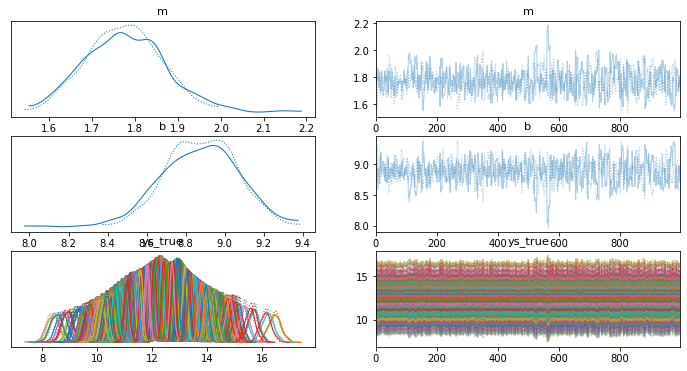

In [10]:
with model:
    pm.plot_trace(trace_linear)   

In this trace, each graph represents the MCMC PDF estimate of a variable. The y axis is the *dP/dx* of the variable while the x axis is the range of values the variable can take.

The two blue gaussians give us the MCMC estimate of the slope and intercept, so now let's plot it and see how well it fits:

Text(0.5, 1.0, 'H-R Diagram of 4 GAIA Data Collections')

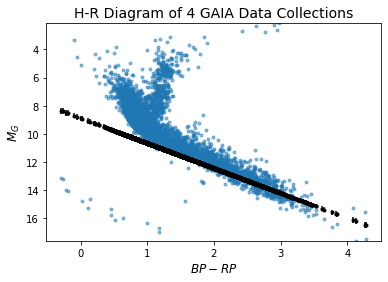

In [11]:
plt.plot(data['bp_rp'], g_abs_mag, '.', alpha=0.5)
# plt.plot(data['bp_rp'], 1.78*data['bp_rp']+8.85)
plt.errorbar(xs, np.mean(trace_linear['ys_true'], axis=0), yerr=std(trace_linear['ys_true'], axis=0), color='k', fmt='.')
plt.ylim(max(g_abs_mag), min(g_abs_mag)) # because magnitudes
plt.ylabel(r"$M_G$", size=12)
plt.xlabel(r"$BP - RP$", size=12)
plt.title("H-R Diagram of 4 GAIA Data Collections", size=14)

Now that doesn't look very good. This is obviously due to the fact that not nearly every star here is on the main sequence, so let's try to sort out these non-MS stars by treating them as outliers:

In [12]:
with pm.Model() as Model:
    m = pm.Normal("m", mu=3, sigma=2)
    b = pm.Normal("b", mu=5, sigma=1)
    
    mu_b = pm.Normal('mu_b', mu=8, sigma=1)
    sigma_b = pm.Lognormal('sigma_b', mu=log(7), sigma=log(4))

    P_giant = pm.Beta("P_giant", alpha = 1, beta=9) # probability that star is not MS
    ys_true = pm.Deterministic('ys_true', m*data['bp_rp'] + b)
    ys_obs = np.array(g_abs_mag)

    logp_good = T.log1p(-P_giant) + pm.Normal.dist(mu=ys_true, sigma=data['phot_g_mean_flux_error']).logp(ys_obs)
    logp_bad = T.log(P_giant) + pm.Normal.dist(mu=mu_b*ones_like(ys_obs), sigma=sigma_b).logp(ys_obs)

    log_odds = pm.Deterministic('log_odds', logp_good - logp_bad)
    _ = pm.Potential('likelihood', T.sum(pm.logaddexp(logp_good, logp_bad)))   

In [13]:
Model.check_test_point()

for RV in Model.basic_RVs:
    print(RV.name, RV.logp(Model.test_point))    

m -1.612085713764618
b -0.9189385332046727
mu_b -0.9189385332046727
sigma_b_log__ -1.2455727931829537
P_giant_logodds__ -1.0536051565782643


In [14]:
with Model:
    mix_trace = pm.sample(draws=1000, tune=1000, chains=1)    

/tmp/ipykernel_265279/3773362446.py:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  mix_trace = pm.sample(draws=1000, tune=1000, chains=1)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [P_giant, sigma_b, mu_b, b, m]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 36 seconds.
The acceptance probability does not match the target. It is 0.8927534928861485, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


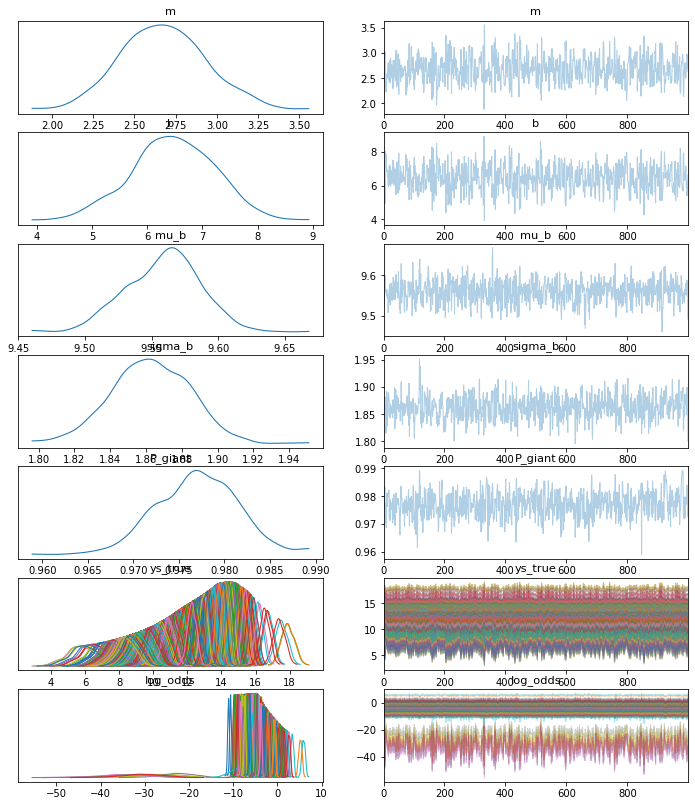

In [15]:
with Model:
    pm.plot_trace(mix_trace)    

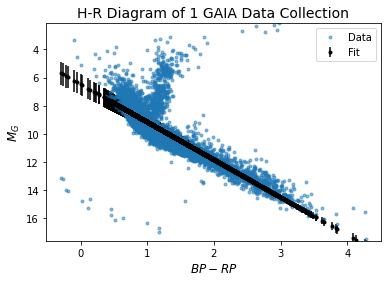

In [16]:
plt.plot(data['bp_rp'], g_abs_mag, '.', alpha=0.5, label='Data')
plt.errorbar(data['bp_rp'], np.mean(mix_trace['ys_true'], axis=0), yerr=std(mix_trace['ys_true'], axis=0), color='k', fmt='.', label='Fit')
plt.ylim(max(g_abs_mag), min(g_abs_mag)) # because magnitudes
plt.ylabel(r"$M_G$", size=12)
plt.xlabel(r"$BP - RP$", size=12)
plt.title("H-R Diagram of 1 GAIA Data Collection", size=14)
plt.legend()

Now THAT looks much more accurate. The MCMC has isolated out the outliers by setting up two distributions. The first distribution is the MS one, where it is a sloping line with very small sigma. The second is the outliers, which is effectively flat but with a very high sigma. The MCMC performs a fitting with each of the distributions while simultaneously attempting to sort out which ones are MS and which ones are outliers.

Just to see which ones it thinks are main sequence, lets do the same plot, but set the transparancy to the log odds of it being on the MS:

Text(0.5, 1.0, 'H-R Diagram of 1 GAIA Data Collection')

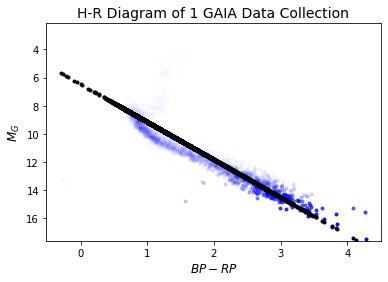

In [17]:
P_good = array(mean(1/(1+exp(-mix_trace['log_odds'])), axis=0))
clr = np.array(data['bp_rp'])


for i in range(len(clr)):
    plt.plot(clr[i], array(g_abs_mag)[i], 'b.', alpha=P_good[i])

plt.plot(data['bp_rp'], np.mean(mix_trace['ys_true'], axis=0), 'k.')

plt.ylim(max(g_abs_mag), min(g_abs_mag)) # because magnitudes
plt.ylabel(r"$M_G$", size=12)
plt.xlabel(r"$BP - RP$", size=12)
plt.title("H-R Diagram of 1 GAIA Data Collection", size=14)

Looks like the classifier did an excellent job at filtering out both the red giants and the white dwarfs and the fitted line matched up really well. It looks like it found a slope of 2.75, meaning that, Luminosity (not magnitude) goes of order color^2.75 with the offset of 6.5 that is the mean value of b